# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords'])

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/juanitasmith/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/juanitasmith/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juanitasmith/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [58]:
# import libraries
import pandas as pd

import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, PredefinedSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.compose import make_column_selector
from imblearn.over_sampling import SMOTEN, SMOTE, RandomOverSampler
from mlsmote import MLSMOTE
from sklearn.ensemble import RandomForestClassifier
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold, RepeatedMultilabelStratifiedKFold
import xgboost as xgb
from sklearn.base import BaseEstimator, TransformerMixin
from tempfile import mkdtemp
from shutil import rmtree

# save and load models
from pickle import dump, load

from src.config import *
from src.helper import *

# clear the garbage to free memory as we are working with huge datasets
import gc

# from custom_transformer import StartingVerbExtractor

# import logging
# logger = logging.getLogger(__name__)

# environment settings
pd.set_option('display.max_column', 400)
pd.set_option('display.max_colwidth', 400)
pd.set_option("display.precision", 300)

In [3]:
random_state = 88

FILE_LOG = '../data/disaster_response.log'

# activate logging
# logging.basicConfig(filename=FILE_LOG, filemode='a', level=logging.INFO)

In [4]:
# load message data from database
engine = create_engine('sqlite:///../data/DisasterResponse.db')
conn = engine.connect()
df = pd.read_sql('select * from messages', con=conn, index_col='id')
df.head()

,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,Weather update - a cold front from Cuba that could pass over Haiti,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Is the Hurricane over or is it not over,direct,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
8,Looking for someone but no name,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.,direct,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
12,"says: west side of Haiti, rest of the country today and tonight",direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25991 entries, 2 to 30265
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   message                 25991 non-null  object
 1   genre                   25991 non-null  object
 2   related                 25991 non-null  int64 
 3   request                 25991 non-null  int64 
 4   offer                   25991 non-null  int64 
 5   aid_related             25991 non-null  int64 
 6   medical_help            25991 non-null  int64 
 7   medical_products        25991 non-null  int64 
 8   search_and_rescue       25991 non-null  int64 
 9   security                25991 non-null  int64 
 10  military                25991 non-null  int64 
 11  water                   25991 non-null  int64 
 12  food                    25991 non-null  int64 
 13  shelter                 25991 non-null  int64 
 14  clothing                25991 non-null  int64 
 15  money  

In [6]:
# try to read message language detection and translation, if it exist
df_language = pd.DataFrame()
try:
    df_language = pd.read_sql('select * from message_language',
                              con=conn,
                              index_col='id',
                              dtype={'is_english': 'boolean'}
                              )
finally:
    pass

# df_language[df_language['is_english'] == False].sample(5)
df_language.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7400 entries, 7976 to 369
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   is_english   7400 non-null   boolean
 1   translation  7400 non-null   object 
dtypes: boolean(1), object(1)
memory usage: 130.1+ KB


In [7]:
# merge dataframes
if len(df_language) > 0:
    df = df.merge(df_language, on='id', how='left' )
    
df.head()

,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,is_english,translation
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,Weather update - a cold front from Cuba that could pass over Haiti,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,
7,Is the Hurricane over or is it not over,direct,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,True,
8,Looking for someone but no name,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,
9,UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.,direct,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,True,
12,"says: west side of Haiti, rest of the country today and tonight",direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,


In [8]:
df.tail()

,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,is_english,translation
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
30261,"The training demonstrated how to enhance micronutrient, protein and energy intake for meals using locally grown horticulture produce, rice and fish.",news,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,NaN
30262,A suitable candidate has been selected and OCHA Jakarta is currently working on her three month-contract starting on the 01st July 2005.,news,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,NaN
30263,"Proshika, operating in Cox's Bazar municipality and 5 other unions, Ramu and Chokoria, assessment, 5 kg rice, 1,5 kg lentils to 700 families.",news,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,NaN
30264,"Some 2,000 women protesting against the conduct of the elections were teargassed as they tried to converge on the local electoral commission offices in the southern oil city of Port Harcourt.",news,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,NaN
30265,"A radical shift in thinking came about as a result of this meeting, recognizing that HIV/AIDS is at the core of the humanitarian crisis and identifying the crisis itself as a function of the HIV/AIDS pandemic.",news,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,NaN


In [9]:
# For messages with no translation or language detection, set is_english = True
df['is_english'] = np.where(df['is_english'].isnull(), True, df['is_english'])
df[df['is_english'] == False][:5]


,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,is_english,translation
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
176,"in what field would you need me to speak creole. French, half english, ( MW? )",direct,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,"In what field would you need me to speak Creole, French, half English?"
342,"Onere and some food. Thanks for your understanding. ( Translator's note : are we getting the full messages? Most of them appear to be bits of sentences, like this one )",direct,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,False,"I need some food. Thanks for your understanding. (Translator's note: are we getting the full messages? Most of them appear to be bits of sentences, like this one)"
383,K aTIS RAP CREOLE. CONTACT ME FAST. FAST VIA SMS OR CALL URGENT it is very very important because it today im gonna do wats I got to do over the bariers am allready waiting,direct,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,"I need help in Creole. Contact me quickly, quickly via SMS or call, it's urgent. It is very important because today I'm going to do what I have to do over the barriers, I'm already waiting."
399,Don't know what to do about estaff touterene part at the end,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,Don't know what to do about the staff routing part at the end
508,We are desperate for food and water. Our organization is Kole Zepol pou'n delivre,direct,1,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,We are desperate for food and water. Our organization is Kole Zepol to deliver


In [10]:
# replace message with translation if message if flagged as not being in English
df['message_new'] =  np.where((df['is_english'] == False) & (~df['translation'].isnull()),
                              df['translation'],
                              df['message'])

In [11]:
# make sure messages already in English are untouched
df[df['is_english'] == True].sample(5)

,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,is_english,translation,message_new
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17537,"In northern Kenya, more 50 lorries carrying foodstuffs, fuel and other essential commodities worth more than Sh100 million destined for Marsabit, Moyale and Ethiopia have been stuck in the mud between Serolevi, Merrille, Loisamis and Loglogo Trading Centres, as massive downpour made the Isiolo/Moyale road impassable.",news,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,True,NaN,"In northern Kenya, more 50 lorries carrying foodstuffs, fuel and other essential commodities worth more than Sh100 million destined for Marsabit, Moyale and Ethiopia have been stuck in the mud between Serolevi, Merrille, Loisamis and Loglogo Trading Centres, as massive downpour made the Isiolo/Moyale road impassable."
336,I need all types of help for the people who survived the earthquake.,direct,1,1,0,1,1,1,1,0,0,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,True,,I need all types of help for the people who survived the earthquake.
27876,"An outbreak of Ebola hemorrhagic fever has killed four Uganda Ministry of Health medical workers this week, including the medical superintendent of Kikyo Health Center in World Vision's Kasitu program area, which is located in the outbreak's epicenter.",news,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,True,NaN,"An outbreak of Ebola hemorrhagic fever has killed four Uganda Ministry of Health medical workers this week, including the medical superintendent of Kikyo Health Center in World Vision's Kasitu program area, which is located in the outbreak's epicenter."
829,"Hello I can't receive call, when someone try to reach me, there's a message saying the number is not available. Please try to fix the problem for me",direct,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,,"Hello I can't receive call, when someone try to reach me, there's a message saying the number is not available. Please try to fix the problem for me"
18609,"Gastrointestinal outbreak - On the 21 of August, the media reported an outbreak of gastrointestinal disease in Guwahati.",news,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,NaN,"Gastrointestinal outbreak - On the 21 of August, the media reported an outbreak of gastrointestinal disease in Guwahati."


In [12]:
# check that messages not in English were replaced
df[df['is_english'] == False][:5]

,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,is_english,translation,message_new
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
176,"in what field would you need me to speak creole. French, half english, ( MW? )",direct,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,"In what field would you need me to speak Creole, French, half English?","In what field would you need me to speak Creole, French, half English?"
342,"Onere and some food. Thanks for your understanding. ( Translator's note : are we getting the full messages? Most of them appear to be bits of sentences, like this one )",direct,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,False,"I need some food. Thanks for your understanding. (Translator's note: are we getting the full messages? Most of them appear to be bits of sentences, like this one)","I need some food. Thanks for your understanding. (Translator's note: are we getting the full messages? Most of them appear to be bits of sentences, like this one)"
383,K aTIS RAP CREOLE. CONTACT ME FAST. FAST VIA SMS OR CALL URGENT it is very very important because it today im gonna do wats I got to do over the bariers am allready waiting,direct,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,"I need help in Creole. Contact me quickly, quickly via SMS or call, it's urgent. It is very important because today I'm going to do what I have to do over the barriers, I'm already waiting.","I need help in Creole. Contact me quickly, quickly via SMS or call, it's urgent. It is very important because today I'm going to do what I have to do over the barriers, I'm already waiting."
399,Don't know what to do about estaff touterene part at the end,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,Don't know what to do about the staff routing part at the end,Don't know what to do about the staff routing part at the end
508,We are desperate for food and water. Our organization is Kole Zepol pou'n delivre,direct,1,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,We are desperate for food and water. Our organization is Kole Zepol to deliver,We are desperate for food and water. Our organization is Kole Zepol to deliver


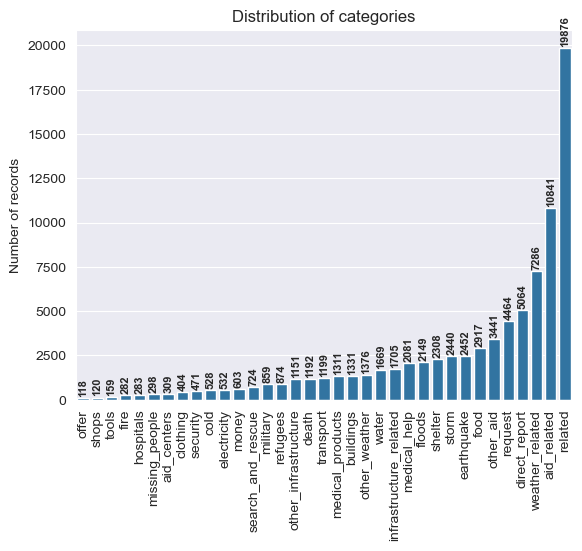

In [13]:
 # plot how categories are distributed
df_sum = df.sum(numeric_only=True).sort_values(ascending=True)
ax = sns.barplot(data=df_sum)

# annotate
for c in ax.containers:
    # set the bar label based on the y-axis
    ax.bar_label(c, padding=1, fontsize=8, rotation=90, weight='bold')
        
plt.xticks(rotation=90)

plt.title('Distribution of categories')
plt.ylabel('Number of records')
plt.show()

## prepare data

In [14]:
df.head()

,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,is_english,translation,message_new
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,Weather update - a cold front from Cuba that could pass over Haiti,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,,Weather update - a cold front from Cuba that could pass over Haiti
7,Is the Hurricane over or is it not over,direct,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,True,,Is the Hurricane over or is it not over
8,Looking for someone but no name,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,,Looking for someone but no name
9,UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.,direct,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,True,,UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.
12,"says: west side of Haiti, rest of the country today and tonight",direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,,"says: west side of Haiti, rest of the country today and tonight"


In [15]:
X = df[['message_new', 'genre']].copy()
X.head()

,message_new,genre
id,,
2,Weather update - a cold front from Cuba that could pass over Haiti,direct
7,Is the Hurricane over or is it not over,direct
8,Looking for someone but no name,direct
9,UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.,direct
12,"says: west side of Haiti, rest of the country today and tonight",direct


In [16]:
y = df.iloc[:, 2:-3].copy()
y.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 2. Write a tokenization function to process your text data

In [17]:
def tokenize(text):
    
    # print('Tokenizer triggered')
    # logger.info('Tokenizer triggered')    
    
    # Does any URL exist in the text, like in our exercises?
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'    
    
    # replace urls with a common keyword
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, 'urlplaceholder')
        
    # normalize text by removing punctuation, remove case and strip spaces
    text = re.sub(r"[^a-zA-Z0-9]", " ", text) 
    text = text.lower().strip()
    
#   split sentence into words
    tokens = word_tokenize(text)
    
    # Remove stopwords, e.g. the, a, 
    # tokens = [w for w in tokens if w not in stopwords.words("english")]    
    
    # take words to their core, e.g. children to child
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok)
        clean_tokens.append(clean_tok) 

    return clean_tokens       

In [18]:
# testing tokenizer
test = df[df['offer'] == 1][:3]
# for message in X['message_new'][:3]:
for message in test['message_new']:
    print(message)
    tokens = tokenize(message)
    print(tokens, '\n')

I am a driver, a mechanic ,. I want to help
['i', 'am', 'a', 'driver', 'a', 'mechanic', 'i', 'want', 'to', 'help'] 

How can we help the victims at Les Cayes?
['how', 'can', 'we', 'help', 'the', 'victim', 'at', 'le', 'cayes'] 

I'm the vice president of the association Rafadek in Anse a galets. You can call me so that you could help people in La Gonave
['i', 'm', 'the', 'vice', 'president', 'of', 'the', 'association', 'rafadek', 'in', 'anse', 'a', 'galets', 'you', 'can', 'call', 'me', 'so', 'that', 'you', 'could', 'help', 'people', 'in', 'la', 'gonave'] 


In [19]:
# Build a custom transformer which will extract the starting verb of a sentence
class StartingVerbExtractor2(BaseEstimator, TransformerMixin):
    """
    Starting Verb Extractor class

    This class extract the starting verb of a sentence,
    creating a new feature for the ML classifier
    """

    def starting_verb(self, text):
        sentence_list = nltk.sent_tokenize(text)

        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            if len(pos_tags) > 0:
                first_word, first_tag = pos_tags[0]
                if first_tag in ['VB', 'VBP', 'VBN', 'VBG'] or first_word == 'RT':
                    return True
        return False

    def fit(self, X, y=None):
        # Given it is a transformer we can return the self 
        return self

    def transform(self, X):
        # apply starting_verb function to all values in X
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)
    

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [20]:
# pos = y_train_sub[y_train_sub == 1].count().sum()

In [21]:
# occ = neg / pos
# occ

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

As the dataset is imbalanced we need to split the data in the same proportions as the actual labels
We will use iterative stratification:
  - as the labelsets are large, 
  - works well with binary relevance
  - handles rare labels in a better way and most important, 
  - maintains the imbalance ratio of each label in each subset

In [22]:
# The size of the test set will be 1/K (i.e. 1/n_splits), so you can tune that parameter to control the test size (e.g. n_splits=3 will have test split of size 1/3 = 33% of your data)

# split data into training and testing dataset
mskf_1 = MultilabelStratifiedKFold(n_splits=6, shuffle=True, random_state=0)

# rmskf = RepeatedMultilabelStratifiedKFold(n_splits=2, n_repeats=2, random_state=0)

for train_index, test_index in mskf_1.split(X, y):
    X_train_val, y_train_val = X.iloc[train_index], y.iloc[train_index]  
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

X_train_val.shape, X_test.shape    


((21659, 2), (4332, 2))

In [23]:
# further split training dataset into train and validation datasets
mskf_2 = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for train_index, val_index in mskf_2.split(X_train_val, y_train_val):
    X_train, y_train = X_train_val.iloc[train_index], y_train_val.iloc[train_index]  
    X_val, y_val = X_train_val.iloc[val_index], y_train_val.iloc[val_index]  
    
X_train.shape, X_val.shape 

((17327, 2), (4332, 2))

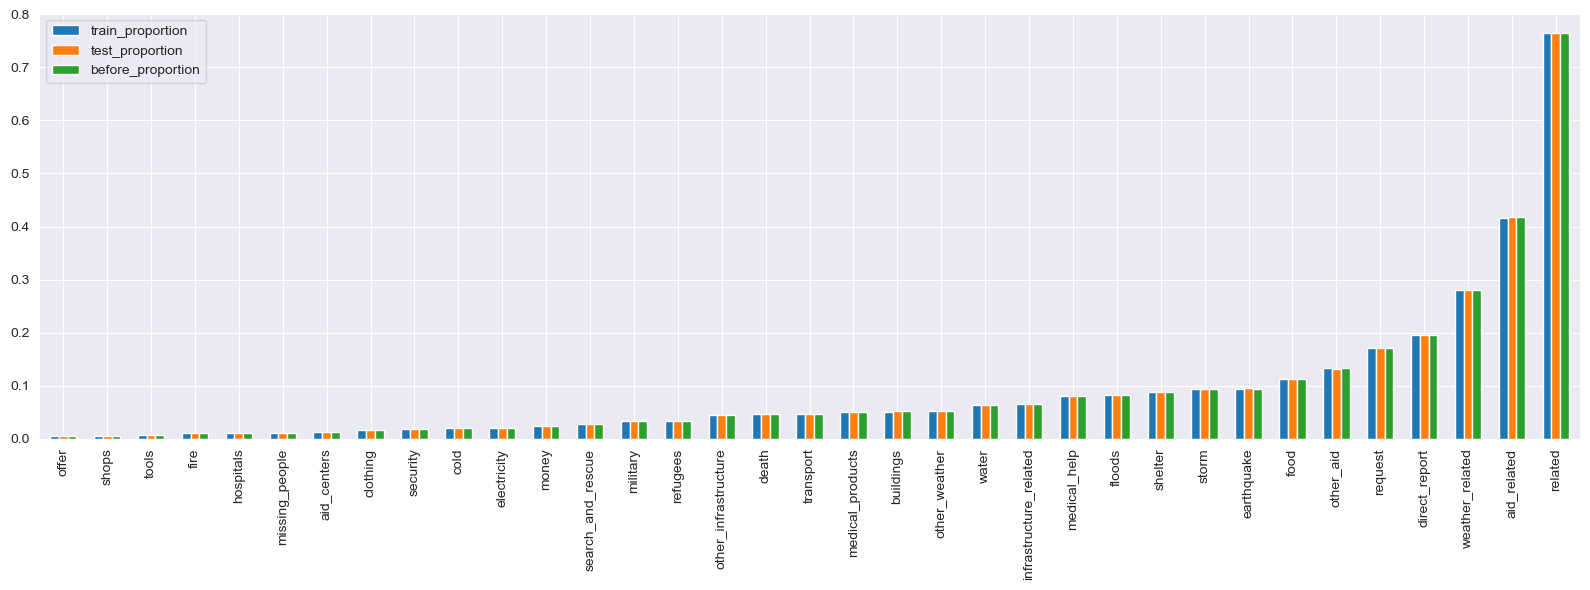

In [24]:
# make sure proportions are the same for original y, test and train datasets
def print_proportions(y, y_train, y_test):
    y_train_prop = (y_train.sum() / y_train.shape[0]).sort_values().to_frame()
    y_train_prop.columns = ['train_proportion']
    y_test_prop = (y_test.sum() / y_test.shape[0]).sort_values().to_frame()
    y_test_prop.columns = ['test_proportion']
    y_prop = (y.sum() / y.shape[0]).sort_values().to_frame()
    y_prop.columns = ['before_proportion']
    all = y_train_prop.merge(y_test_prop, left_index=True, right_index=True)
    all = all.merge(y_prop, left_index=True, right_index=True)
    all = all.reindex(y_prop.index)
    all.plot(kind='bar', width=0.6, sharey=True, sharex=True, stacked=False, figsize=(16,6))
    plt.tight_layout()

print_proportions(y, y_train, y_test)

> Label were split in the same proportions between train, validation and test datasets

In [25]:
# TODO
# now we need to oversample the minority classes

In [26]:
def get_tail_label(y: pd.DataFrame) -> list:
    """
    Find the underrepresented targets.
    Underrepresented targets are those which are observed less than the median occurrence.
    """
    # irlbl = y.sum(axis=0)
    # irlbl = irlbl.max() / irlbl
    # threshold_irlbl = irlbl.mean()
    # tail_label = irlbl[irlbl > threshold_irlbl].index.tolist()
    # print(tail_label)
    # return tail_label
   
    # irlbl = y.sum(axis=0)
    # print(irlbl)
    # irlbl = irlbl.max() / irlbl
    # threshold_irlbl = irlbl.mean()
    # tail_label = irlbl[irlbl > threshold_irlbl].index.tolist()
    # print(tail_label)
    
    grand_total = y.sum(axis=0).sum()
    irlbl = y.sum(axis=0)/grand_total
    # threshold_irlbl = irlbl.median()
    threshold_irlbl = irlbl.quantile(0.25)
    tail_label = irlbl[irlbl < threshold_irlbl].index.tolist()     
    
    return tail_label


def get_minority_samples(X: pd.DataFrame, y: pd.DataFrame):
    """
    Filter datasets containing records with imbalanced targets
    
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    tail_labels = get_tail_label(y)
    index = y[y[tail_labels].apply(lambda x: (x == 1).any(), axis=1)].index.tolist()
    X_sub = X.loc[index]
    y_sub = y.loc[index]
    print('Imbalanced labels: {}'.format(tail_labels))
    return X_sub, y_sub, tail_labels

def get_sample_ratio(df: pd.DataFrame):
    """
    Find the underrepresented targets.
    Underrepresented targets are those which are observed less than the median occurrence.
    Targets beyond a quantile limit are filtered.
    """
    
    tail_labels = get_tail_label(df)
    full_count = df.sum(axis=0)    
    ratio = np.where(full_count.index.isin(tail_labels), np.ceil((full_count.mean()) / full_count), 1)    
    ratio = pd.Series(ratio, index=full_count.index)    
    return ratio  

def transform(X, y):
  
    # calculate the ratio each label should be duplicated to be balanced
    counts = get_sample_ratio(y_train)

    # filter datasets with rows that contain imbalanced features
    X_sub, y_sub, tail_labels = get_minority_samples(X, y)   
    print('Minority samples: {} {}'.format(X_sub.shape, y_sub.shape))
    
    # replace class binary indicator with it's ratio of duplication
    y_sub_copy = y_sub.copy()
    labels = y_sub.columns.to_list()
    for label in labels:
        # print(label, counts[label])
        y_sub_copy[label] = y_sub_copy[label].apply(lambda x: x * counts[label])    
    
    X_list = []
    y_list = []
    for i in range(y_sub.shape[0]):
        # for each row, get label with maximum ratio
        max_label = y_sub_copy.iloc[i].idxmax()
        # how many times should we copy this row ?
        nr_copies = int(counts[max_label])
        # get index of row to be copied
        index = y_sub.iloc[i].name
        # print(max_label, nr_copies, index)
        # duplicate the rows according to ratio of imbalance
        for _ in range(nr_copies):
            y_list.append(y_sub.iloc[i])
            X_list.append(X_sub.iloc[i])
           
    X_sub_new = pd.DataFrame(X_list, columns=X_train.columns.to_list())
    y_sub_new = pd.DataFrame(y_list, columns=y_train.columns.to_list())
    
    X_sub_new = pd.concat([X, X_sub_new])
    y_sub_new = pd.concat([y, y_sub_new])
    
    return X_sub_new, y_sub_new, tail_labels
    

In [27]:
# get_sample_ratio(y_train)

In [28]:
print('Training shapes before: {} {}'.format(X_train.shape, y_train.shape)) 
X_train_sub, y_train_sub, imbalanced_labels = transform(X_train, y_train)
print('Duplicated samples: {} {}'.format(X_train_sub.shape, y_train_sub.shape))    

Training shapes before: (17327, 2) (17327, 35)
Imbalanced labels: ['offer', 'security', 'clothing', 'missing_people', 'tools', 'hospitals', 'shops', 'aid_centers', 'fire']
Minority samples: (1384, 2) (1384, 35)
Duplicated samples: (30500, 2) (30500, 35)


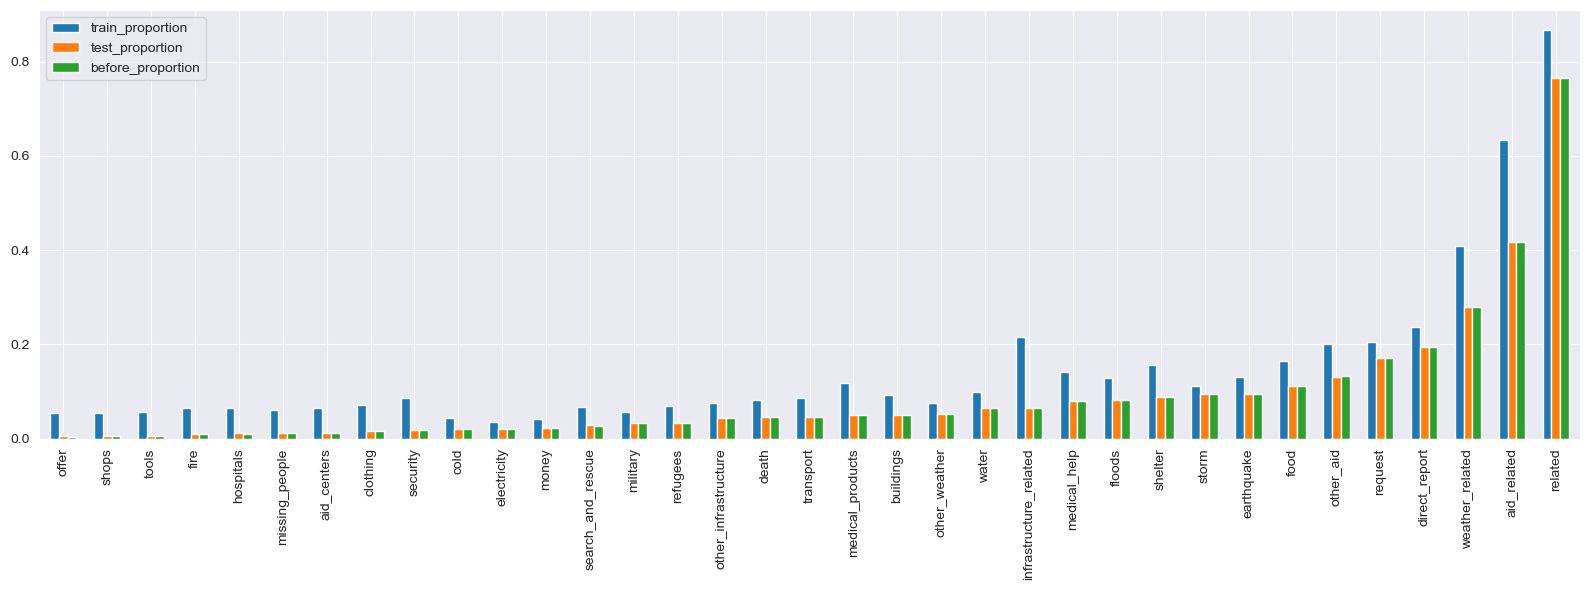

In [29]:
print_proportions(y, y_train_sub, y_test)

In [30]:
neg = y_train_sub[y_train_sub['offer'] == 0].count().sum()
pos = y_train_sub[y_train_sub['offer'] == 1].count().sum()
ratio = neg / pos

In [31]:
# cache transformers so they are only executed once, especially during gridsearch
cachedir = mkdtemp()
# memory = Memory(location=cachedir, verbose=1)

params = {
    'objective': 'binary:logistic',
    'n_jobs': 4,
    'max_depth': 5,
    'min_child_weight': 1,
    'gamma': 0,
    'learning_rate': 0.1,
    'eval_metric': 'aucpr',
    # 'eval_metric': 'error',    
    'booster': 'gbtree',
    # 'random_state': random_state,
    'n_estimators': 50,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'tree_method': 'hist',
    'scale_pos_weight': 1,
    # 'max_delta_step': 1,
    # 'device': 'gpu',
    # 'early_stopping_rounds': 20,
    'verbosity': 2,
    'seed' : random_state,
    'nthread': 4,
    # 'enable_categorical': True,

}

text_pipe = Pipeline(steps=[
    ('vect', CountVectorizer(tokenizer=tokenize, token_pattern=None)),    
    ('tfidf', TfidfTransformer(sublinear_tf=True)),    
    # ('scale', StandardScaler(with_mean=False)),
    ],
    verbose=True)

# preprocessor for NLP
preprocessor_text = ColumnTransformer(transformers=[
    ('text_vect', text_pipe, 'message_new'),
],
    verbose_feature_names_out=False,
    remainder='drop',
    verbose=True,
)

# preprocessor for genre column to convert to binary
preprocessor_bin = ColumnTransformer(transformers=[
    ('one_hot', OneHotEncoder(), ['genre']),
],
    remainder='drop',
    verbose=True,
)

preprocessor = Pipeline([
    ('feature_union', FeatureUnion([

        ('text_processing', preprocessor_text),

        ('one_hot', preprocessor_bin),

    ],
        verbose=True, 
    ))])


full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', MultiOutputClassifier(xgb.XGBClassifier(**params))),
],
    memory=cachedir,
    verbose=True,
)

In [32]:
# train classifier
full_pipeline.fit(X_train_sub, y_train_sub)
rmtree(cachedir)

[Pipeline] .............. (step 1 of 2) Processing vect, total=   7.1s
[Pipeline] ............. (step 2 of 2) Processing tfidf, total=   0.0s
[ColumnTransformer] ..... (1 of 1) Processing text_vect, total=   7.2s
[FeatureUnion]  (step 1 of 2) Processing text_processing, total=   7.2s
[ColumnTransformer] ....... (1 of 1) Processing one_hot, total=   0.0s
[FeatureUnion] ....... (step 2 of 2) Processing one_hot, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   7.2s
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.6min


### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.


Use GridSearchCV for hyper parameter training, however use the validation dataset for evaluation to avoid data leakage.

Because the eval_set needs to be transformed first, I use PredinedSplit so that the validation dataset is transformed internally.

In [33]:
# Evaluate results
y_pred_val = evaluate(X_val, y_val, full_pipeline, zero_division=0)
print_results(y_val, y_pred_val, full_pipeline)

                        precision    recall  f1-score   support

               related       0.79      0.99      0.88      3312
               request       0.77      0.57      0.66       744
                 offer       0.33      0.05      0.09        19
           aid_related       0.56      0.86      0.68      1840
          medical_help       0.60      0.20      0.30       346
      medical_products       0.68      0.21      0.32       218
     search_and_rescue       0.61      0.14      0.23       121
              security       0.22      0.03      0.05        78
              military       0.74      0.19      0.31       144
                 water       0.76      0.71      0.74       278
                  food       0.80      0.80      0.80       486
               shelter       0.79      0.55      0.65       385
              clothing       0.80      0.64      0.71        67
                 money       0.54      0.20      0.29       101
        missing_people       0.64      

### 6. Improve your model with GridSearch
Use grid search to find better parameters. 

Scoring to consider for imbalance is: f1_micro, f1_weighted, roc_auc, auc
Set parameter max_delta_step to a finite number (say 1) to help convergence

[Click here to see XGBOOST documenation how to handle Imbalance](https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html#handle-imbalanced-dataset)

In [34]:
# beta > 1 favors recall, whilst beta = 0.5 favors precision
# ftwo_scorer = make_scorer(fbeta_score, beta=2)

# scoring = 'tfwo_scorer'
scoring = 'f1_micro'
verbose = 2

In [35]:
# full_pipeline.get_params()

In [36]:
# def cv_predefined(X_train, y_train, X_val, y_val, pipeline, hyperparameters, scoring='roc_auc', verbose=3, error_score=np.nan):
# 
#     # Build a predefined split with validation set to be used for evaluation
# 
#     # Merge training and validation set back together
#     X_train_val = pd.concat([X_train, X_val])
#     y_train_val = pd.concat([y_train, y_val])
# 
#     # Create a list where train data indices are -1 and validation data indices are 0
#     split_index = [0 if x in X_val.index else -1 for x in X_train_val.index]
#     pds = PredefinedSplit(test_fold=split_index)
#     print('Number of training splits: {}'.format(pds.get_n_splits()))
# 
#     # create grid search object
#     gridsearch = GridSearchCV(pipeline,
#                       param_grid=hyperparameters,
#                       refit=False,
#                       return_train_score=True,
#                       # n_jobs=4,
#                       scoring=scoring,
#                       # cv=MultilabelStratifiedKFold(n_splits=2, shuffle=True, random_state=0),
#                       cv=pds,       
#                       verbose=verbose,
#                       error_score=error_score
#                       )
# 
#     # compare results of both training and validation datasets
#     gridsearch.fit(X_train_val, y_train_val)
# 
#     print('\nBest score: {}'.format(gridsearch.best_score_))
#     print("\nBest Parameters:", gridsearch.best_params_)
# 
#     rmtree(cachedir)
# 
#     return gridsearch

## Step 0 - NGram range

To help the model to consider context better, would it better to work with individual words or collection of words ?

In [37]:
# clear the garbage to free memory
gc.collect()

12533

In [38]:
# values = [(1,1), (2,2), (3,3)]
# 
# hyperparameters = {
#     'preprocessor__feature_union__text_processing__text_vect__vect__ngram_range' : values,
# }
# 
# gridsearch1 = cv_predefined(X_train=X_train,
#                             y_train=y_train,
#                             X_val=X_val,
#                             y_val=y_val,
#                             pipeline=full_pipeline,
#                             hyperparameters=hyperparameters,
#                             scoring=scoring,                          
#                             verbose=verbose)

In [39]:
# Update model parameters with cross validation results
# full_pipeline.set_params(**gridsearch1.best_params_)
# full_pipeline.fit(X_train_sub, y_train_sub)
# y_pred_val = evaluate(X_val, y_val, full_pipeline)
# print_results(y_val, y_pred_val, full_pipeline)
# cv_plot_scores(gridsearch1)

## Step 2 - Tune pos_weight

Controlling Imbalance

Balancing of positive and negative weights to handle imbalance

In [40]:
gc.collect()

0

In [41]:
hyperparameters = {
    'clf__estimator__scale_pos_weight' : [1, 2, 3, 4, ratio, 25],
    'clf__estimator__max_delta_step' : [1, 2, 3, 4, 5],    
}

gridsearch2 = cv_predefined(X_train=X_train_sub,
                            y_train=y_train_sub,
                            X_val=X_val,
                            y_val=y_val,
                            pipeline=full_pipeline,
                            hyperparameters=hyperparameters,
                            scoring=scoring,                  
                            verbose=verbose)

rmtree(cachedir)

Number of training splits: 1
Fitting 1 folds for each of 15 candidates, totalling 15 fits
[Pipeline] .............. (step 1 of 2) Processing vect, total=   7.2s
[Pipeline] ............. (step 2 of 2) Processing tfidf, total=   0.0s
[ColumnTransformer] ..... (1 of 1) Processing text_vect, total=   7.2s
[FeatureUnion]  (step 1 of 2) Processing text_processing, total=   7.2s
[ColumnTransformer] ....... (1 of 1) Processing one_hot, total=   0.0s
[FeatureUnion] ....... (step 2 of 2) Processing one_hot, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   7.3s
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.8min
[CV] END clf__estimator__max_delta_step=1, clf__estimator__scale_pos_weight=1; total time= 1.9min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.9min
[CV] END clf__estimator__max_delta_step=1, clf__estimator__scale_pos_weight=5; total time= 1.9min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.9min
[CV

[Pipeline] .............. (step 1 of 2) Processing vect, total=  34.6s
[Pipeline] ............. (step 2 of 2) Processing tfidf, total=   0.2s
[ColumnTransformer] ..... (1 of 1) Processing text_vect, total=  34.9s
[FeatureUnion]  (step 1 of 2) Processing text_processing, total=  34.9s
[ColumnTransformer] ....... (1 of 1) Processing one_hot, total=   0.0s
[FeatureUnion] ....... (step 2 of 2) Processing one_hot, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=  35.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total= 5.0min
                        precision    recall  f1-score   support

               related       0.79      0.99      0.88      3312
               request       0.77      0.57      0.65       744
                 offer       0.50      0.05      0.10        19
           aid_related       0.56      0.86      0.68      1840
          medical_help       0.55      0.20      0.29       346
      medical_products       0.64      0.20   

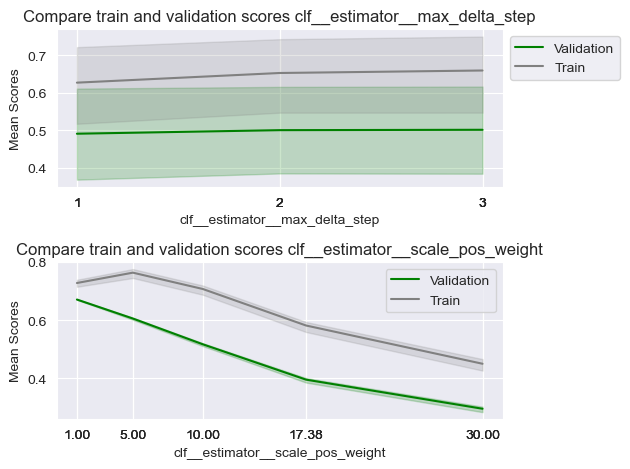

In [42]:
# Update model parameters with cross validation rsults
full_pipeline.set_params(**gridsearch2.best_params_)
full_pipeline.fit(X_train_sub, y_train_sub)
y_pred_val = evaluate(X_val, y_val, full_pipeline)
print_results(y_val, y_pred_val, full_pipeline)
cv_plot_scores(gridsearch2)

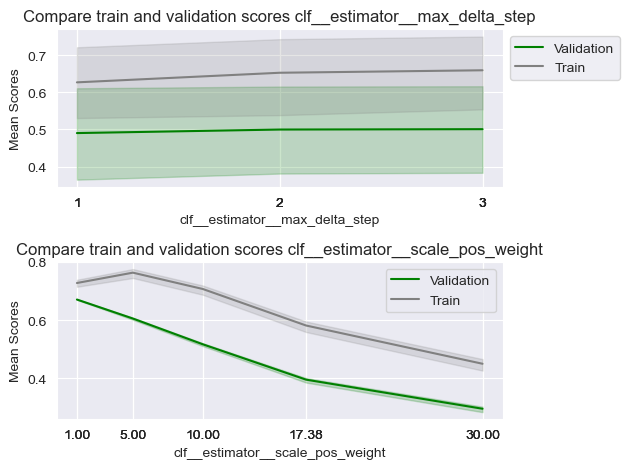

In [43]:
cv_plot_scores(gridsearch2)

## Step 3 - Grid search for max depth and min child weight

Control Overfitting and model complexity

In [44]:
# hyperparameters = {
#     'clf__estimator__max_depth' : [6, 8, 10, 15, 20],
#     'clf__estimator__min_child_weight': [1, 2, 4, 6]
# }

hyperparameters = {
    'clf__estimator__max_depth' : [4, 6, 8, 10, 15],
    'clf__estimator__min_child_weight': [1, 2, 3, 4, 5, 6]
}

gridsearch3 = cv_predefined(X_train=X_train_sub,
                            y_train=y_train_sub,
                            X_val=X_val,
                            y_val=y_val,
                            pipeline=full_pipeline,
                            hyperparameters=hyperparameters,
                            scoring=scoring,                            
                            verbose=verbose)

rmtree(cachedir)

Number of training splits: 1
Fitting 1 folds for each of 30 candidates, totalling 30 fits
[Pipeline] ............... (step 2 of 2) Processing clf, total= 3.6min
[CV] END clf__estimator__max_depth=4, clf__estimator__min_child_weight=1; total time= 3.7min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 3.3min
[CV] END clf__estimator__max_depth=4, clf__estimator__min_child_weight=2; total time= 3.4min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 2.7min
[CV] END clf__estimator__max_depth=4, clf__estimator__min_child_weight=3; total time= 9.3min
[Pipeline] ............... (step 2 of 2) Processing clf, total=  56.7s
[CV] END clf__estimator__max_depth=4, clf__estimator__min_child_weight=4; total time=  58.2s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  54.6s
[CV] END clf__estimator__max_depth=4, clf__estimator__min_child_weight=5; total time=  56.2s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  53.6s
[CV] END clf__estim

In [45]:
# Update model parameters with cross validation rsults
full_pipeline.set_params(**gridsearch3.best_params_)
full_pipeline.fit(X_train_sub, y_train_sub)
y_pred_val = evaluate(X_val, y_val, full_pipeline)
print_results(y_val, y_pred_val, full_pipeline)

[Pipeline] .............. (step 1 of 2) Processing vect, total=   8.7s
[Pipeline] ............. (step 2 of 2) Processing tfidf, total=   0.0s
[ColumnTransformer] ..... (1 of 1) Processing text_vect, total=   8.7s
[FeatureUnion]  (step 1 of 2) Processing text_processing, total=   8.7s
[ColumnTransformer] ....... (1 of 1) Processing one_hot, total=   0.0s
[FeatureUnion] ....... (step 2 of 2) Processing one_hot, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   8.7s
[Pipeline] ............... (step 2 of 2) Processing clf, total= 6.5min
                        precision    recall  f1-score   support

               related       0.82      0.96      0.89      3312
               request       0.77      0.60      0.67       744
                 offer       0.00      0.00      0.00        19
           aid_related       0.69      0.75      0.72      1840
          medical_help       0.59      0.21      0.31       346
      medical_products       0.64      0.23   

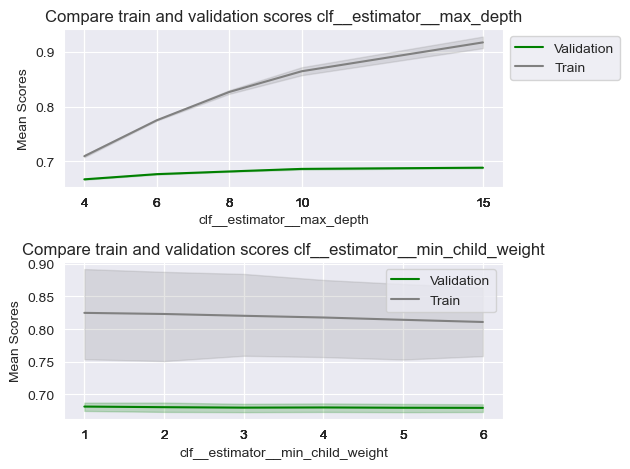

In [46]:
cv_plot_scores(gridsearch3)

## Step 4 - Tune Gamma

In [47]:
hyperparameters = {
    'clf__estimator__gamma': [1, 5, 9, 10, 12, 15, 20],
}

gridsearch4 = cv_predefined(X_train=X_train_sub,
                            y_train=y_train_sub,
                            X_val=X_val,
                            y_val=y_val,
                            pipeline=full_pipeline,
                            hyperparameters=hyperparameters,
                            scoring=scoring,
                            verbose=verbose)

rmtree(cachedir)

Number of training splits: 1
Fitting 1 folds for each of 9 candidates, totalling 9 fits
[Pipeline] ............... (step 2 of 2) Processing clf, total= 8.9min
[CV] END ..........................clf__estimator__gamma=0.1; total time= 9.0min
[Pipeline] ............... (step 2 of 2) Processing clf, total=12.8min
[CV] END ...........................clf__estimator__gamma=0; total time=132.8min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 4.2min
[CV] END ...........................clf__estimator__gamma=10; total time= 4.2min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 2.4min
[CV] END ...........................clf__estimator__gamma=30; total time= 2.4min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 4.5min
[CV] END ...........................clf__estimator__gamma=35; total time= 4.6min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 4.4min
[CV] END ...........................clf__estimator__gamma=40; total time= 4.5min


In [48]:
# Update model parameters with cross validation rsults
full_pipeline.set_params(**gridsearch4.best_params_)
full_pipeline.fit(X_train_sub, y_train_sub)
y_pred_val = evaluate(X_val, y_val, full_pipeline)
print_results(y_val, y_pred_val, full_pipeline)

[Pipeline] .............. (step 1 of 2) Processing vect, total=  34.4s
[Pipeline] ............. (step 2 of 2) Processing tfidf, total=   0.2s
[ColumnTransformer] ..... (1 of 1) Processing text_vect, total=  34.6s
[FeatureUnion]  (step 1 of 2) Processing text_processing, total=  34.6s
[ColumnTransformer] ....... (1 of 1) Processing one_hot, total=   0.0s
[FeatureUnion] ....... (step 2 of 2) Processing one_hot, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=  34.8s
[Pipeline] ............... (step 2 of 2) Processing clf, total= 9.6min
                        precision    recall  f1-score   support

               related       0.83      0.96      0.89      3312
               request       0.76      0.61      0.68       744
                 offer       0.00      0.00      0.00        19
           aid_related       0.66      0.78      0.72      1840
          medical_help       0.56      0.25      0.34       346
      medical_products       0.66      0.27   

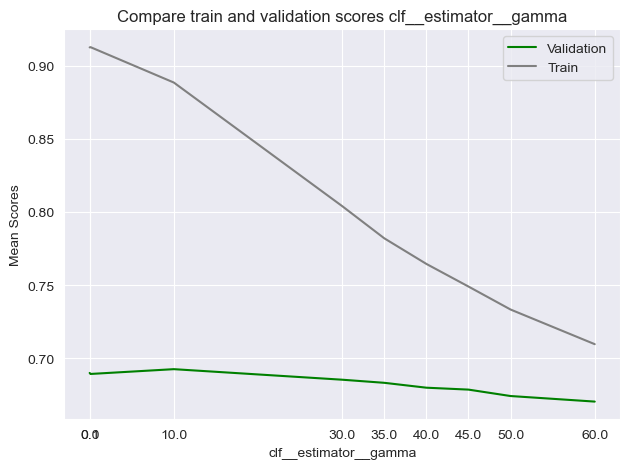

In [49]:
cv_plot_scores(gridsearch4)

## Step 5 - Tune subsample and colsample_bytree

In [50]:
hyperparameters = {
    'clf__estimator__subsample': [0.7, 0.8, 0.9, 1], 
    'clf__estimator__colsample_bytree': [0.7, 0.8, 0.9, 1],     
}

gridsearch5 = cv_predefined(X_train=X_train_sub,
                            y_train=y_train_sub,
                            X_val=X_val,
                            y_val=y_val,
                            pipeline=full_pipeline,
                            hyperparameters=hyperparameters,
                            scoring=scoring,
                            verbose=verbose)

rmtree(cachedir)

Number of training splits: 1
Fitting 1 folds for each of 16 candidates, totalling 16 fits
[Pipeline] ............... (step 2 of 2) Processing clf, total= 4.5min
[CV] END clf__estimator__colsample_bytree=0.6, clf__estimator__subsample=0.6; total time=124.4min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 3.2min
[CV] END clf__estimator__colsample_bytree=0.6, clf__estimator__subsample=0.7; total time= 3.2min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 5.9min
[CV] END clf__estimator__colsample_bytree=0.6, clf__estimator__subsample=0.8; total time= 6.0min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 8.2min
[CV] END clf__estimator__colsample_bytree=0.6, clf__estimator__subsample=0.9; total time= 8.3min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 6.9min
[CV] END clf__estimator__colsample_bytree=0.7, clf__estimator__subsample=0.6; total time= 7.0min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 6.0mi

In [51]:
# Update model parameters with cross validation rsults
full_pipeline.set_params(**gridsearch5.best_params_)
full_pipeline.fit(X_train_sub, y_train_sub)
y_pred_val = evaluate(X_val, y_val, full_pipeline)
print_results(y_val, y_pred_val, full_pipeline)

[Pipeline] .............. (step 1 of 2) Processing vect, total=   6.9s
[Pipeline] ............. (step 2 of 2) Processing tfidf, total=   0.0s
[ColumnTransformer] ..... (1 of 1) Processing text_vect, total=   6.9s
[FeatureUnion]  (step 1 of 2) Processing text_processing, total=   6.9s
[ColumnTransformer] ....... (1 of 1) Processing one_hot, total=   0.0s
[FeatureUnion] ....... (step 2 of 2) Processing one_hot, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   6.9s
[Pipeline] ............... (step 2 of 2) Processing clf, total= 2.9min
                        precision    recall  f1-score   support

               related       0.82      0.96      0.89      3312
               request       0.76      0.62      0.68       744
                 offer       0.00      0.00      0.00        19
           aid_related       0.67      0.79      0.72      1840
          medical_help       0.58      0.24      0.34       346
      medical_products       0.67      0.25   

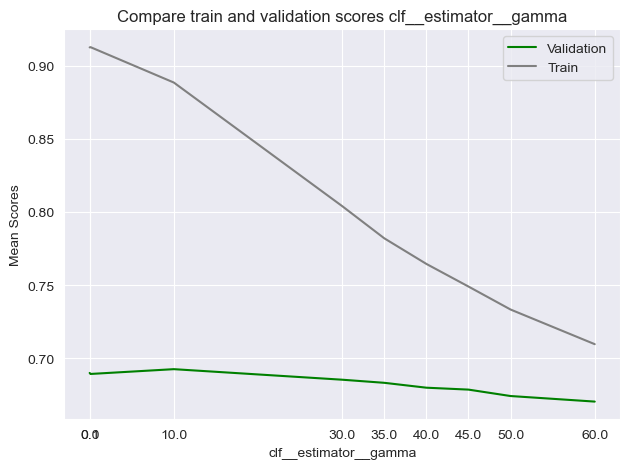

In [52]:
cv_plot_scores(gridsearch4)

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [57]:
full_pipeline.get_params()

{'memory': '/var/folders/4p/r9m3gynn3wj6h4yh4_lwz5fw0000gn/T/tmp1kls0myr',
 'steps': [('preprocessor',
   Pipeline(steps=[('feature_union',
                    FeatureUnion(transformer_list=[('text_processing',
                                                    ColumnTransformer(transformers=[('text_vect',
                                                                                     Pipeline(steps=[('vect',
                                                                                                      CountVectorizer(token_pattern=None,
                                                                                                                      tokenizer=<function tokenize at 0x7fcd59995790>)),
                                                                                                     ('tfidf',
                                                                                                      TfidfTransformer(sublinear_tf=True))],
                      

In [53]:
# add dummy variable

# pipeline = Pipeline([
#     ('features', FeatureUnion([
# 
#         ('text_pipeline', Pipeline([
#             ('vect', CountVectorizer(tokenizer=tokenize, token_pattern=None)),
#             ('tfidf', TfidfTransformer()),
# 
#         ])),
# 
#         ('starting_verb', StartingVerbExtractor2())
# 
#     ])),
# 
#     ('clf', MultiOutputClassifier(xgb.XGBClassifier(**params))),
# ],
#     memory=cachedir,
#     verbose=True,
# )

In [54]:
# XGBOOST have a multilabel predictor build, how does that perform ?

# def fpreproc(dtrain, dtest, param):
#     label = dtrain.get_label()
#     ratio = float(np.sum(label == 0)) / np.sum(label == 1)
#     param["scale_pos_weight"] = ratio
#     return (dtrain, dtest, param)


# do cross validation, for each fold
# the dtrain, dtest, param will be passed into fpreproc
# then the return value of fpreproc will be used to generate
# results of that fold
# param = {"max_depth": 2, "eta": 1, "objective": "binary:logistic"}

# param = {
#     'max_depth' : [8, 12, 20], 
# }
# num_round = 2
# 
# res = xgb.cv(param,
#              X_train_sub['message_new'],
#              num_boost_round=2,
#              nfold=5,
#              metrics={"auc"},
#              seed=0,
#              scoring='f1_micro',
#              stratified=True,
#              callbacks=[
#                 xgb.callback.EvaluationMonitor(show_stdv=False),
#                 xgb.callback.EarlyStopping(3),
#                  ]
#              )


### 9. Export your model as a pickle file

In [60]:
# save fitted models

dump(full_pipeline, open('../models/model_f1_micro.pkl', 'wb'))

### 10. Use this notebook to complete `train_classifier.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

https://cookbook.openai.com/examples/batch_processing

https://videolectures.net/ecmlpkdd2011_tsoumakas_stratification/?q=stratification%20multi%20label

https://datascience.stackexchange.com/questions/45174/how-to-use-sklearn-train-test-split-to-stratify-data-for-multi-label-classificat

https://www.kaggle.com/code/tolgadincer/upsampling-multilabel-data-with-mlsmote

[Oversampling](https://www.kaggle.com/code/thedrcat/oversampling-for-multi-label-classification)

[Creating Balanced Multi-Label Datasets for Model Training and Evaluation](https://medium.com/gumgum-tech/creating-balanced-multi-label-datasets-for-model-training-and-evaluation-16b6a3a2d912)


[MLSMOTE for MoA](https://www.kaggle.com/code/yassinealouini/mlsmote-for-moa)

[Creating balanced multilabel datasets comparing multiple libraries](https://medium.com/gumgum-tech/creating-balanced-multi-label-datasets-for-model-training-and-evaluation-16b6a3a2d912)

[xgboost for LLMS](https://www.kaggle.com/code/vbmokin/llm-20-feature-xgboost-after-deobfuscation/notebook

[How to use xgboost multi label](https://xgboost.readthedocs.io/en/latest/python/examples/multioutput_regression.html#sphx-glr-python-examples-multioutput-regression-py)

[XGBOOST is all you need](https://www.kaggle.com/code/lucamassaron/easy-peasy-eda-xgboost-is-all-you-need/notebook)

https://www.kaggle.com/code/tilii7/hyperparameter-grid-search-with-xgboost

[Mastering XGBoost Parameters Tuning](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

[Nested pipelines](https://gist.github.com/amberjrivera/8c5c145516f5a2e894681e16a8095b5c)

[Using predefined split during cross validation](https://stackoverflow.com/questions/31948879/using-explicit-predefined-validation-set-for-grid-search-with-sklearn)

[Using GridSearchCV to validate against validation dataset](https://stackoverflow.com/questions/46815252/using-scikit-learn-gridsearchcv-for-cross-validation-with-predefinedsplit-susp)

[Plotting training vs validation cross validation scores](https://www.kaggle.com/code/willcanniford/predicting-back-pain-with-sklearn-and-gridsearchcv)

[Early stopping](https://stackoverflow.com/questions/78178902/is-there-example-of-xgb-xgbregressor-with-callbacks-early-stop-early-stop-xgb)

[XGBOOST Notes on Parameter Tuning](https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html#handle-imbalanced-dataset)

Sagemaker
https://subscription.packtpub.com/book/data/9781801817950/2/ch02lvl1sec05/setting-up-amazon-sagemaker-on-your-local-machine

clf__estimator__max_delta_step=3, clf__estimator__scale_pos_weight=30; 
Best Parameters: {'clf__estimator__max_depth': 15, 'clf__estimator__min_child_weight': 4}
Best Parameters: {'clf__estimator__gamma': 10}
Best Parameters: {'clf__estimator__colsample_bytree': 0.9, 'clf__estimator__subsample': 0.7}

